In [1]:
import pandas as pd
import os
import gc
import json
from pathlib import Path
import seaborn as sns
import numpy as np
from collections import defaultdict
from scipy.interpolate import interp1d, interp2d, splrep, splev
from scipy.optimize import minimize, brentq
from itertools import product
%matplotlib inline

In [2]:
store = pd.HDFStore('../data/all-data.h5')

In [3]:
def get_stat(df):
    return pd.Series({
        'STD': df['reldelta'].std(),
        'mean': df['reldelta'].mean(),
        'MARE': abs(df['reldelta']).mean(),
        'MAE': abs(df['delta']).mean()
    })
    
def get_deltas(df):
    return df \
        .assign(delta=lambda x: x['ene']-x['ref']) \
        .assign(reldelta=lambda x: x['delta']/abs(x['ref']))

In [4]:
data = pd.merge(
    store['scan_mods'].loc['S22'].reset_index(),
    store['mbd'].loc['S22'].reset_index(),
    on='system',
    how='inner',
    suffixes=('_scf', '_mbd')
).set_index('system params beta'.split()).sort_index() \
    .assign(ene=lambda x: x['ene_scf']+x['ene_mbd'])

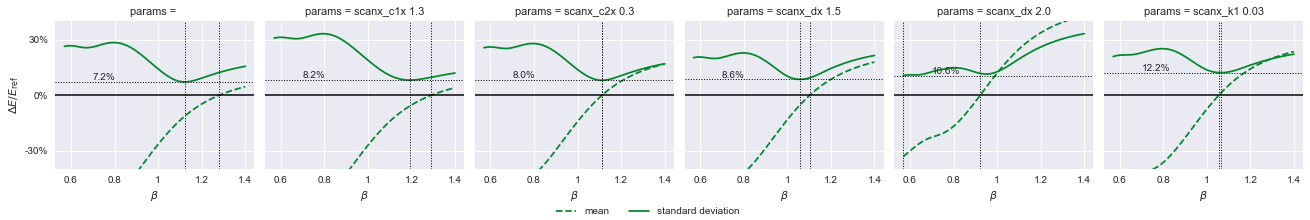

In [5]:
def plot_stat(**kwargs):
    global line1, line2
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    line1, = sns.plt.plot(beta, mean(beta), '--', color='#00882B')
    line2, = sns.plt.plot(beta, std(beta), '-', color='#00882B')
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1.6, bounds=bounds).x[0]
    opt_mean = brentq(mean, *bounds[0]) \
            if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])) \
            else bounds[0][1]
    sns.plt.axhline(color='black', lw=1.5)
    sns.plt.axhline(std(opt_std), color='black', ls='dotted', lw=1)
    sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)
    sns.plt.text(.7, std(opt_std)+.01, f'{100*float(std(opt_std)):.1f}%')

g = sns.FacetGrid(
    data.loc[(slice(None), [
        '',
        'scanx_c1x 1.3',
        'scanx_c2x 0.3',
        'scanx_dx 1.5',
        'scanx_dx 2.0',
        'scanx_k1 0.03'
    ], slice(None, 1.5)), :]
    .pipe(get_deltas).reset_index(),
    col='params',
    margin_titles=True
).map_dataframe(plot_stat)
g.fig.legend(
    (line1, line2), ('mean', 'standard deviation'),
    loc='upper center', bbox_to_anchor=(.5, .1), ncol=2
)
g.fig.subplots_adjust(bottom=0.2)
sns.plt.ylim(-.4, .4)
g.set_xlabels(r'$\beta$')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
xticks = [.6, .8, 1, 1.2, 1.4]
yticks = [-.3, 0, .3]
g.set(xticks=xticks, yticks=yticks)
g.set_xticklabels(xticks)
g.set_yticklabels(['-30%', '0%', '30%'])